# REFERENCE - benchmark structural regression

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import matplotlib as mpl
import sys
from math import *
from scipy.stats import binned_statistic
import inspect
from Bio import SeqIO
from pathlib import Path
sns.set_theme(style="white", context="talk")
import glob
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import itertools
from scipy import stats



from utils_benchmark import * 
#test()

sns.set_context("talk")


def get_stats(scores_df, summary_homfam_exthomfam):
    stats_alignments = pd.merge(scores_df, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
    stats_alignments["approach"] = stats_alignments[["method", "bucket_size", "master_msa", "slave_msa", "dynamicX_val", "align_method", "tree_method"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    stats_alignments["approach"] = stats_alignments.approach.apply(lambda val: val.replace("_nan",""))
    stats_alignments["fam_approach"] = stats_alignments["family"]+"_"+stats_alignments["approach"]
    stats_alignments.tc = pd.to_numeric(stats_alignments.tc)
    return(stats_alignments)
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

In [2]:
evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"
seqs_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/refs/"
# Load reference stats 
stats_alignments_ref= pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "stats_alignments_refs.csv"))
summary_homfam_merged_tosave = pd.read_csv(os.path.join("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/", "02_summary_homfam_with_refs.csv"))

# Extract AF2 info for references only # Load AF2 scores
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
# Load datasets informations (Homfam + extHomfam)
summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})


In [3]:
# Extract all sequences in reference 
summary_ref_af2 = pd.DataFrame()
for f in listdir(seqs_dir):
     if f.endswith("fa"):
        fasta_sequences = SeqIO.parse(open(os.path.join(seqs_dir,f)),'fasta')
        for fasta in fasta_sequences:
            seq_id = [fasta.id.replace("/","_")]
            l = len(fasta.seq.replace("-", ""))
            entry = pd.DataFrame({'sequence': seq_id,"length":l, "name": [f.replace("-ref.fa","").strip()]})
            summary_ref_af2 =  pd.concat([summary_ref_af2, entry], ignore_index = True)
summary_ref_af2["subset"] = "ref"
summary_ref_af2["family"] = summary_ref_af2.name
summary_ref_af2 = summary_ref_af2.merge(af2, on = ["sequence", "family"])
af2_homfam_summary = summary_ref_af2.groupby(['family',"benchmarking_dataset"]).agg({'plddt': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "benchmarking_dataset", "plddt_mean", "plddt_min", "plddt_max"], axis=1)

summary_homfam_merged_tosave["family"] = summary_homfam_merged_tosave.familcombined
summary_ref = pd.merge(summary_homfam_merged_tosave,af2_homfam_summary)

# plddt of ALL reference seqs

Text(0.5, 0.98, 'n=772')

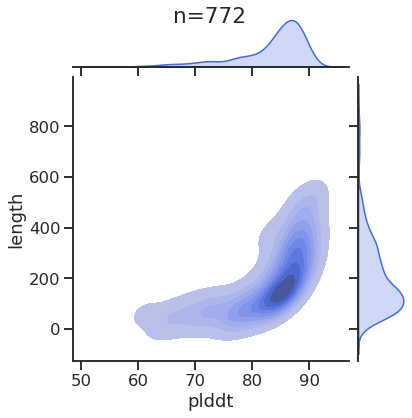

In [4]:
sns.set_theme(style="ticks")
sns.set_context("talk")


ax = sns.jointplot(
    data=summary_ref_af2,  fill=True, color = "royalblue", legend = False, 
    x="plddt", y="length",
    kind="kde"
)

nobs = summary_ref_af2['sequence'].value_counts().sum()

# Add it to the plot
#ax.fig.text(1,1,nobs,horizontalalignment='center',size='small',color='red')
ax.fig.suptitle("n="+str(nobs))

In [5]:
summary_ref_af2[summary_ref_af2.family == "GEL"]

,sequence,length,name,subset,family,plddt,benchmarking_dataset
326,1d0na2,127,GEL,ref,GEL,80.5300,homfam
327,1d0na1,121,GEL,ref,GEL,77.5940,homfam
328,1svr,94,GEL,ref,GEL,76.2979,homfam
329,1yagg,125,GEL,ref,GEL,84.5248,homfam
330,2vil,126,GEL,ref,GEL,76.6237,homfam


# Load references MSAs 

In [6]:
# Define dataset 
dataset = "homfam"
scores_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/score/")

scores = pd.DataFrame()
for score_name in os.listdir(scores_dir):
    score_file = os.path.join(scores_dir,score_name)
    # Parse file
    if score_file.endswith(".scores"):
        # only keep references
        if "-ref" in score_file:
            score_df = pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1)
            scores = pd.concat([scores, score_df])
scores = scores.iloc[:,0:4]
scores.columns = ['name', 'sp', 'tc', 'column']

# Extract subsets of interest

In [7]:
# -------------------------
#      Regressive
# -------------------------
regressive_scores = scores[scores.name.str.contains("regressive")]
regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Progressive
# -------------------------
progressive_scores = scores[scores.name.str.contains("progressive")]
progressive_scores[["family", "method", "align_method", "tree_method"]] = progressive_scores.name.str.split(".", expand = True)

# -------------------------
#      Dyanmic
# -------------------------
dynamic_scores = scores[scores.name.str.contains("dynamic")]
dynamic_scores[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val","master_msa", "slave_msa", "tree_method"]] = dynamic_scores.name.str.split(".", expand = True)


# --------------   summary all -----------------
scores_df = pd.concat([regressive_scores, progressive_scores, dynamic_scores], ignore_index=True, sort=False)

scores_df.family = scores_df.family.str.replace("-ref","")
scores_df["benchmarking_dataset"] = dataset

stats_alignments_ref = get_stats(scores_df, summary_homfam_exthomfam)

df = stats_alignments_ref
df.nref = df.n_sequences * df.perc_ref_total /100 

df = pd.merge(df, summary_ref, on = "family")

/tmp/ipykernel_9444/3451490122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
/tmp/ipykernel_9444/3451490122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
/tmp/ipykernel_9444/3451490122.py:5: SettingWithCopyWarning: 
A 

In [9]:
scores_df

,name,sp,tc,column,family,method,bucket_size,align_method,tree_method,dynamicX_label,dynamicX_val,master_msa,slave_msa,benchmarking_dataset
0,cryst-ref.regressive.50.FAMSA.FAMSA-medoid,63.8,1.7,0.8,cryst,regressive,50,FAMSA,FAMSA-medoid,NaN,NaN,NaN,NaN,homfam
1,scorptoxin-ref.regressive.1000.FAMSA.FAMSA-medoid,95.4,86.3,90.0,scorptoxin,regressive,1000,FAMSA,FAMSA-medoid,NaN,NaN,NaN,NaN,homfam
2,KAS-ref.regressive.1000.FAMSA.FAMSA-medoid,88.2,72.2,77.0,KAS,regressive,1000,FAMSA,FAMSA-medoid,NaN,NaN,NaN,NaN,homfam
3,lyase-1-ref.regressive.50.FAMSA.FAMSA-medoid,77.5,59.4,59.9,lyase-1,regressive,50,FAMSA,FAMSA-medoid,NaN,NaN,NaN,NaN,homfam
4,hom-ref.regressive.1000.FAMSA.FAMSA-medoid,98.1,79.7,95.3,hom,regressive,1000,FAMSA,FAMSA-medoid,NaN,NaN,NaN,NaN,homfam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,tms-ref.dynamic.50.dynamicX.1000.famsa_msa.fam...,96.3,85.6,91.5,tms,dynamic,50,NaN,FAMSA-medoid,dynamicX,1000,famsa_msa,famsa_msa,homfam
1253,ricin-ref.dynamic.50.dynamicX.1.famsa_msa.fams...,91.8,77.3,84.9,ricin,dynamic,50,NaN,FAMSA-medoid,dynamicX,1,famsa_msa,famsa_msa,homfam
1254,ltn-ref.dynamic.50.dynamicX.1000.famsa_msa.fam...,94.3,72.7,80.2,ltn,dynamic,50,NaN,FAMSA-medoid,dynamicX,1000,famsa_msa,famsa_msa,homfam
1255,ricin-ref.dynamic.50.dynamicX.1000.famsa_msa.f...,91.8,77.3,84.9,ricin,dynamic,50,NaN,FAMSA-medoid,dynamicX,1000,famsa_msa,famsa_msa,homfam


In [8]:
# Comparison 1: DYNAMIC w/ 3D
df_dyn_3d = df[df.approach == "dynamic_50_tcoffee_msa_famsa_msa_100000000_FAMSA-medoid"]
#df_dyn_3d["nref"] = df_dyn_3d.n_sequences * df_dyn_3d.perc_ref_total /100 

# Comparison 2: DYNAMIC w/ FAMSA 
df_dyn_famsa = df[df.approach == "dynamic_50_famsa_msa_famsa_msa_100000000_FAMSA-medoid"]

# Comparison 3: PROGRESSIVE w/ 3D 
df_prog_3d = df[df.approach == "progressive_3DCOFFEE_FAMSA-medoid"]
df_prog_3d_mbed = df[df.approach == "progressive_3DCOFFEE_MBED"]

# Comparison 3: PROGRESSIVE w/ 3D 
df_prog_3d_probapair = df[df.approach == "progressive_PROBAPAIR_FAMSA-medoid"]
df_prog_3d_probapair_mbed = df[df.approach == "progressive_PROBAPAIR_MBED"]

# For sanity checks, MBED 
df_prog_3d_expresso = df[df.approach == "progressive_EXPRESSOREAL_MBED"]
df_prog_3dcoffee = df[df.approach == "progressive_3DCOFFEE_MBED"]
df_prog_famsa = df[df.approach == "progressive_FAMSA_MBED"]


# Comparison 4: PROGRESSIVE w/ FAMSA
df_prog_famsa_medoid = df[df.approach == "progressive_FAMSA_FAMSA-medoid"]

# BUG SANITY CHECK 

#### Separate the exact classes we want the comparison with 

In [9]:
df = pd.concat([df_dyn_3d, df_dyn_famsa, df_prog_3d, df_prog_famsa])

#### Do 3D progressive and 3D dyanmic give the same (aka --> any bug in dynamic --> NO)

In [10]:
# Do 3D progressive and 3D dyanmic give the same (aka --> any bug in dynamic --> NO)
df_dyn_3d_red = df_dyn_3d[["family","tc"]]
df_prog_3d_red = df_prog_3d[["family", "tc"]]
df_3d_all = pd.merge(df_dyn_3d_red, df_prog_3d_red, on = "family")
#np.array(df_3d_all.tc_x == df_3d_all.tc_y)

#### Do 3D COFFEE and 3D PROBAPAIR give the same?  no (aka --> WE ARE USING THE STRUCTURES)


In [11]:
# Do 3D COFFEE and 3D PROBAPAIR give the same?  no (aka --> WE ARE USING THE STRUCTURES)
df1_red = df_dyn_3d[["family","tc"]]
df2_red = df_prog_3d_probapair[["family", "tc"]]
df_all = pd.merge(df1_red, df2_red, on = "family")
#np.array(df_all.tc_x == df_all.tc_y)

In [12]:
# Do 3D progressive and 3D dyanmic give the same : we are using different trees options! 
# Take a decision on what to keep and mae it consistent!!
df_dyn_famsa_red = df_dyn_famsa[["family","tc"]]
df_prog_famsa_red = df_prog_famsa[["family", "tc"]]
df_famsa_all = pd.merge(df_dyn_famsa_red, df_prog_famsa_red, on = "family")
#np.array(df_famsa_all.tc_x ==df_famsa_all.tc_y)

# TC SANITY CHECK 

## With my approach I cannot retrieve the same templates 

In [13]:
# Check which structures are getting used in Expresso 
templates = pd.DataFrame()
# Collect templates
for name in glob.glob('/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/structures/search_hits/mmseqs/*-ref/*/template.txt'):
    fam_name_complete= name.split("/")[-3]
    family = fam_name_complete.replace("-ref", "")
    template_df = pd.read_csv(name, sep = " ", header = None)
    ntemplate = len(template_df.index)
    new_row = pd.DataFrame({"family_complete":[fam_name_complete], "family": [family],'ntemplates':[ntemplate]})
    templates = pd.concat([templates,new_row])
# Per family check the number of structures in template
# pd.merge(summary_ref,templates, on  = "family")[["family", "n_sequences_ref", "ntemplates"]]

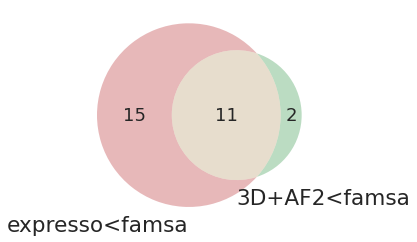

In [14]:
df_expresso_famsa = pd.merge(df_prog_3d_expresso, df_prog_famsa, on = ["family"] )
df_dynamic_famsa = pd.merge(df_dyn_3d,df_prog_famsa, on = ["family"] )
df_dynamic_famsa = df_dynamic_famsa[df_dynamic_famsa.family.isin(list(df_expresso_famsa.family))]
expresso_less_famsa = list(df_expresso_famsa[df_expresso_famsa.sp_x < df_expresso_famsa.sp_y ]["family"])
dynamic_less_famsa = list(df_dynamic_famsa[df_dynamic_famsa.sp_x < df_dynamic_famsa.sp_y ]["family"])
set1 = set(expresso_less_famsa)
set2 = set(dynamic_less_famsa)
venn2([set1, set2], ('expresso<famsa', '3D+AF2<famsa'))
plt.show()

[Text(0, 0.5, '3D+AF2 SP - FAMSA'),
 Text(0.5, 0, ''),
 [Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, ''),
  Text(26, 0, ''),
  Text(27, 0, ''),
  Text(28, 0, ''),
  Text(29, 0, ''),
  Text(30, 0, ''),
  Text(31, 0, ''),
  Text(32, 0, ''),
  Text(33, 0, ''),
  Text(34, 0, ''),
  Text(35, 0, ''),
  Text(36, 0, ''),
  Text(37, 0, ''),
  Text(38, 0, ''),
  Text(39, 0, ''),
  Text(40, 0, ''),
  Text(41, 0, ''),
  Text(42, 0, ''),
  Text(43, 0, ''),
  Text(44, 0, ''),
  Text(45, 0, ''),
  Text(46, 0, ''),
  Text(47, 0, ''),
  Text(48, 0, ''),
  Text(49, 0, ''),
  Tex

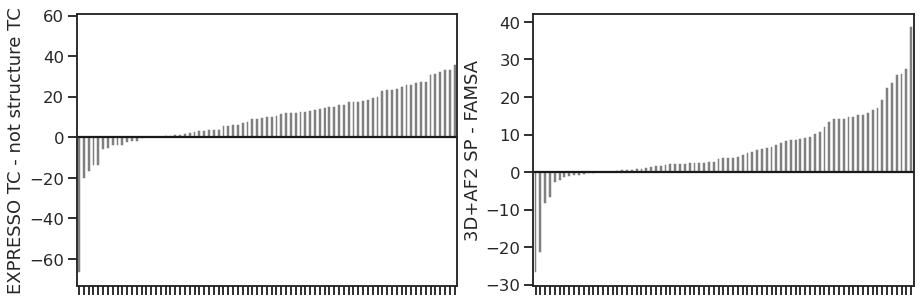

In [15]:
## Hypothesis one: expresso with PDB should be higher than famsa
## Also i could check if families where we do worse with structures, whether its AF2 or is the structural alignment

df_d_r = pd.merge(df_prog_3dcoffee, df_prog_famsa, on = ["family"] )
df_d_r["diff_tc"] = df_d_r.tc_x - df_d_r.tc_y 
df_d_r["diff_sp"] = df_d_r.sp_x - df_d_r.sp_y 
df_d_r["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r.tc_y) 

# Set up the matplotlib figure
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

# Center the data to make it diverging
sns.barplot(x=df_d_r.diff_tc, y=df_d_r.diff_tc, color ="grey", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set(ylabel="EXPRESSO TC - not structure TC", xlabel = "", xticklabels="")

# Center the data to make it diverging
sns.barplot(x=df_d_r.diff_sp, y=df_d_r.diff_sp, color ="grey", ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set(ylabel="3D+AF2 SP - FAMSA", xlabel = "", xticklabels="")


### Exploration - why could that happen? 

<AxesSubplot:xlabel='diff_qualitatively', ylabel='n_sequences_x'>

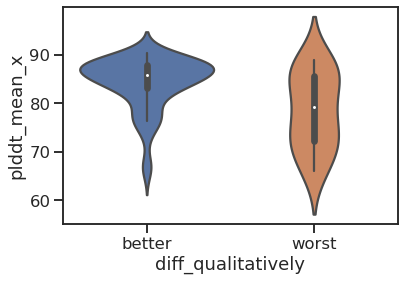

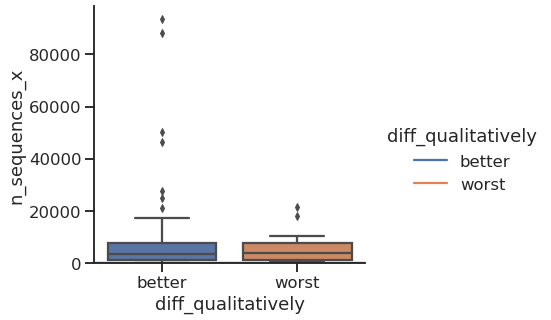

In [16]:
# Which are the ones for which we do not get ? 
family_worst = list(df_d_r[df_d_r.diff_tc < 0].family)
df_d_r["diff_qualitatively"] = "better"
df_d_r.loc[df_d_r.diff_tc < 0, 'diff_qualitatively'] = "worst"
df_d_r.diff_qualitatively.value_counts()

sns.violinplot(data = df_d_r, y = "plddt_mean_x", x = "diff_qualitatively")
sns.displot(df_d_r, x = "n_sequences_x", hue = "diff_qualitatively", kind = "kde")
sns.boxplot(data = df_d_r, y = "n_sequences_x", x = "diff_qualitatively")


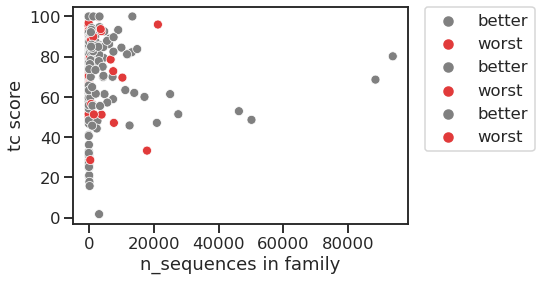

In [17]:
# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "perc_change_tc", y = "tc_y", hue = "diff_qualitatively").set(ylabel = "tc (no structure)", xlabel = "% change tc scores")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, x = "mean_length_x", y = "plddt_mean_x", hue = "diff_qualitatively")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Create an array with the colors you want to use
colors = ["grey", "#E13A3A"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(data = df_d_r, y = "tc_x", x = "n_sequences_x", hue = "diff_qualitatively").set(xlabel  ="n_sequences in family", ylabel = "tc score")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [18]:
df_d_r.columns

Index(['name_x', 'sp_x', 'tc_x', 'column_x', 'family', 'method_x',
       'bucket_size_x', 'align_method_x', 'tree_method_x', 'dynamicX_label_x',
       'dynamicX_val_x', 'master_msa_x', 'slave_msa_x',
       'benchmarking_dataset_x_x', 'subset_x', 'n_sequences_x',
       'mean_length_x', 'min_length_x', 'max_length_x', 'file_x',
       'size_group_x', 'perc_ref_total_x_x', 'approach_x', 'fam_approach_x',
       'familcombined_x', 'subset_ref_x', 'n_sequences_ref_x',
       'mean_length_ref_x', 'min_length_ref_x', 'maref_length_ref_x',
       'file_ref_x', 'subset_combined_x', 'n_sequences_combined_x',
       'mean_length_combined_x', 'min_length_combined_x',
       'maref_length_combined_x', 'file_combined_x', 'perc_ref_total_y_x',
       'benchmarking_dataset_y_x', 'plddt_mean_x', 'plddt_min_x',
       'plddt_max_x', 'name_y', 'sp_y', 'tc_y', 'column_y', 'method_y',
       'bucket_size_y', 'align_method_y', 'tree_method_y', 'dynamicX_label_y',
       'dynamicX_val_y', 'master_msa_y',

# General metrics exploration

## Load % identity and TCS 

In [19]:
# ---------------------------------------------------------
# Get SIMILARITY per family 
# Get number of sequences per family (and store for future notebooks)
# ---------------------------------------------------------

sims = os.path.join(evaluation_dir,"homfam/evaluation/sim/*.sim")
sim_df = pd.DataFrame()

for file in list(glob.glob(sims)):
    full_name = file.split(sep = "/")[-1].replace(".sim", "")
    file_opened = open(file, "r")
    tot_line = [line.split() for line in file_opened if line.startswith('TOT')]
    entry = pd.DataFrame({'name': [full_name],"sim_tot": tot_line[0][3]})
    sim_df =  pd.concat([sim_df, entry], ignore_index = True)

# ---------------------------------------------------------
# Get TCS (and store for future notebooks) 
# ---------------------------------------------------------

tcss = os.path.join(evaluation_dir,"homfam/evaluation/tcs/*.tcs")
tcss_3d = os.path.join(evaluation_dir,"homfam/alignments/*/*/*.tcs")
tcs_paths = list(glob.glob(tcss)) + list(glob.glob(tcss_3d))
tcs_df = pd.DataFrame()

for file in tcs_paths:
    full_name = file.split(sep = "/")[-1].replace(".tcs", "")
    file_opened = open(file, "r")
    tot_line = [line.split(sep = "=") for line in file_opened if line.startswith('SCORE')]
    entry = pd.DataFrame({'name': [full_name],"tcs_tot": tot_line[0][1].strip()})
    tcs_df =  pd.concat([tcs_df, entry], ignore_index = True)

In [32]:
tcs_df

,name,tcs_tot
0,aat-ref.progressive.FAMSA.MBED,721
1,annexin-ref.progressive.FAMSA.MBED,997
2,blmb-ref.progressive.FAMSA.MBED,545
3,uce-ref.progressive.FAMSA.MBED,861
4,lyase_1-ref.progressive.FAMSA.MBED,717
...,...,...
183,asp-ref.progressive.3DCOFFEE.MBED,985
184,GEL-ref.progressive.3DCOFFEE.MBED,991
185,HLH-ref.progressive.3DCOFFEE.MBED,972
186,hip-ref.progressive.3DCOFFEE.MBED,981


In [20]:
# Add stats
df_prog_famsa_stats = pd.merge(df_prog_famsa,sim_df, on = "name")
df_prog_famsa_stats = pd.merge(df_prog_famsa_stats,tcs_df, on = "name")

df_prog_3dcoffee_stats = pd.merge(df_prog_3dcoffee,sim_df, on = "name")
df_prog_3dcoffee_stats = pd.merge(df_prog_3dcoffee_stats,tcs_df, on = "name")

In [21]:
df_d_r = pd.merge(df_prog_3dcoffee_stats, df_prog_famsa_stats, on = ["family"] )
df_d_r["diff_tc"] = df_d_r.tc_x - df_d_r.tc_y 
df_d_r["diff_sp"] = df_d_r.sp_x - df_d_r.sp_y 
df_d_r["perc_change_tc"]= df_d_r.diff_tc *100/ abs(df_d_r.tc_y)
df_d_r["perc_change_sp"]= df_d_r.diff_sp *100/ abs(df_d_r.sp_y)

df_d_r.columns = [c.replace("_x", "_3D") for c in list(df_d_r.columns)]
df_d_r.columns = [c.replace("_y", "_FAMSA") for c in list(df_d_r.columns)]

df_d_r["diff_qualitatively"] = "better"
df_d_r.loc[df_d_r.perc_change_sp < 0, 'diff_qualitatively'] = "worst "
df_d_r.loc[df_d_r.perc_change_sp < -10, 'diff_qualitatively'] = "worst -10 "

df_d_r["tcs_tot_3D"]= df_d_r["tcs_tot_3D"].astype('int')
df_d_r["sim_tot_3D"]= df_d_r["sim_tot_3D"].astype('float')
df_d_r["tcs_tot_FAMSA"]= df_d_r["tcs_tot_FAMSA"].astype('int')
df_d_r["sim_tot_FAMSA"]= df_d_r["sim_tot_FAMSA"].astype('float')

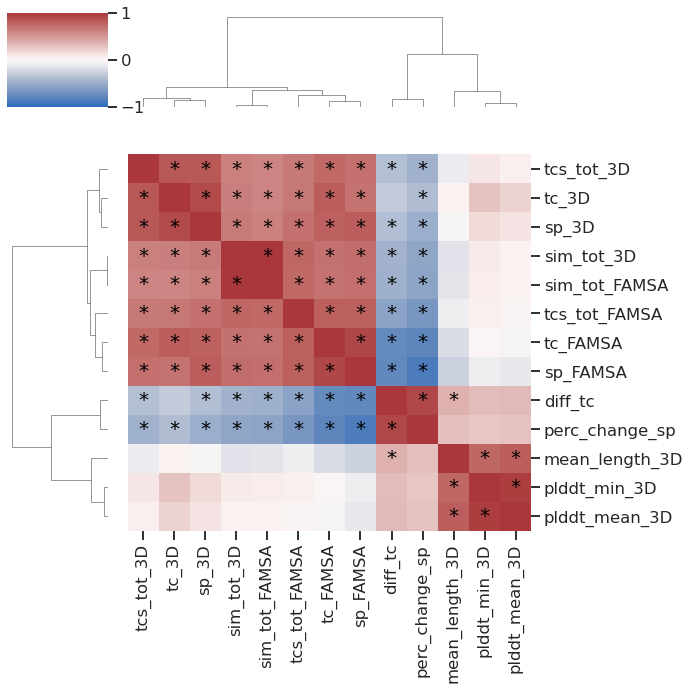

In [22]:

df_correlation = df_d_r[["diff_tc","tc_3D","tc_FAMSA","sp_3D","sp_FAMSA", "mean_length_3D", "plddt_min_3D", "plddt_mean_3D", "sim_tot_3D", "tcs_tot_3D", "sim_tot_FAMSA", "tcs_tot_FAMSA", "perc_change_sp"]]

#df_correlation.columns = ["diff_tc", "tc_structure", "tc_nostructure", "n_sequences_family", "mean_length", "plddt_mean"]
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
def get_correlations(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    for ix, r in enumerate(df.columns):
        for jx, c in enumerate(df.columns):
            sp = spearmanr(df[r], df[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan  # Only store values below the diagonal
    return correlations.astype("float"), pvalues.astype("float")


correlations, uncorrected_p_values = get_correlations(df_correlation)

# Correct p-values for multiple testing and check significance (True if the corrected p-value < 0.05)
shape = uncorrected_p_values.values.shape
significant_matrix = multipletests(uncorrected_p_values.values.flatten())[0].reshape(
    shape
)

# Here we start plotting
g = sns.clustermap(correlations, cmap="vlag", vmin=-1, vmax=1)

# Here labels on the y-axis are rotated
for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

# Here we add asterisks onto cells with signficant correlations
for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if significant_matrix[ix, jx] or significant_matrix[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

# Save a high-res copy of the image to disk
plt.tight_layout()
plt.savefig("clustermap.png", dpi=200)

## Extract GDT_TS

In [163]:
# Collect all the gdt files 
gdt_summary = pd.DataFrame()
for file in glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/pdbs/structures/eval_gdt/*/*.txt"):
    gdt = pd.read_csv(file, header = None)
    gdt_summary = pd.concat([gdt_summary, gdt])
gdt_summary = gdt_summary.rename(columns={0: "family", 1: "sequence", 2: "metric", 3: "value"})
gdtss = gdt_summary[gdt_summary["metric"] == "GDT-TS"]
gdtss = gdtss.groupby(['family']).agg({'value': ['mean', 'min', 'max']}).reset_index().set_axis(["family", "gdt_mean", "gdt_min", "gdt_max"], axis=1)
gdtss["gdt_mean"] = gdtss["gdt_mean"].astype("float") * 100
gdtss["gdt_min"] = gdtss["gdt_min"].astype("float") * 100 
gdtss["gdt_max"] = gdtss["gdt_max"].astype("float") * 100

In [164]:
# Add GDT to the df 
df_d_r_wgdt = df_d_r.merge(gdtss, on = "family")
df_d_r_wgdt["sp_3D"] = df_d_r_wgdt["sp_3D"].astype(float)
df_d_r_wgdt["tc_3D"] = df_d_r_wgdt["tc_3D"].astype(float)
msa_qualities = df_d_r_wgdt[["family", "sp_3D", "tc_3D"]]

In [165]:
# Check the amount of matches after filtering mmseqs
mmseqs_summary = pd.DataFrame()
for file in glob.glob("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/homfam/pdbs/structures/search_hits/mmseqs/*/*/filtered_hits.m8"):
    family = os.path.basename(os.path.dirname(file)).replace("-ref.PDB", "")
    with open(file, 'r') as fp:
        nhits = len(fp.readlines())
    entry = pd.DataFrame({'family':[family], 'nhits': nhits})
    mmseqs_summary =  pd.concat([mmseqs_summary, entry], ignore_index = True)

In [166]:
# Check that I am extracting all the references 
n_ref_structures  = gdt_summary[gdt_summary["metric"] == "GDT-TS"].groupby(['family']).agg({'sequence': ['count']}).reset_index().set_axis(["family", "n_ref_structures"], axis = 1)
df_test = df_d_r.merge(n_ref_structures, on = "family", how = "left")
df_test = df_test[["family","n_sequences_ref_3D", "n_ref_structures"]]
df_test = df_test.merge(mmseqs_summary, on = "family", how = "left")
df_test = df_test.replace(np.nan, 0)

In [167]:
# 1. Quantify the loss in number of sequences and make sure is due to the mmseqs not 100% hit ( check and parse filter hits file)
#    First the mmseqs sanity check --> needs to be empty. If full, the reported family is problematic.
df_test[(df_test.n_sequences_ref_3D > df_test.n_ref_structures) & ( df_test.n_ref_structures < df_test.nhits)]
# How many sequences per family do I loose? 
df_test["loss"] = df_test.n_sequences_ref_3D - df_test.n_ref_structures
df_test.loss.sum()
# What I want to know 
# 1 - total % of loss 
total_amount_references = df_test.n_sequences_ref_3D.sum()
references_with_experimental_structure = df_test.n_ref_structures.sum()
print("Total number of reference sequences in Homfam: " + str(total_amount_references))
print("Total number of retrieved structures: " + str(references_with_experimental_structure))
print("Sequences with missing structures: "+ str(total_amount_references - references_with_experimental_structure))
print("% loss: "+ str((total_amount_references - references_with_experimental_structure)*100/total_amount_references))
# And also the %of loss (and absolute numbers) per family 
df_test["perc_loss"] = df_test.loss*100/df_test.n_sequences_ref_3D
df_test["loss"] = df_test["loss"].astype(float)
df_test["perc_loss"] = df_test["perc_loss"].astype(float)

Total number of reference sequences in Homfam: 780
Total number of retrieved structures: 723.0
Sequences with missing structures: 57.0
% loss: 7.3076923076923075


In [168]:
# In how many families do I loose at least one structure? 
df_test_loss = df_test[df_test.loss > 0]
df_test_loss = df_test_loss.sort_values(by='perc_loss', ascending=True)
print(df_test_loss.family.count())
df_test_loss[df_test_loss.perc_loss > 30].family.count()

familes_no_loss = list(df_test[df_test.loss == 0].family)

24


[Text(0.5, 0, '% of ref missing structure')]

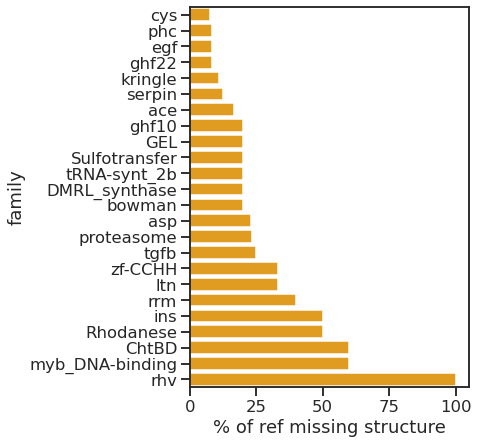

In [169]:
plt.figure(figsize=(5,7))
ax= sns.barplot(x='perc_loss', y='family', data=df_test_loss, ci=None, color = "orange")
ax.set(xlabel='% of ref missing structure')


In [93]:
# --------------------------------- TODO ----------------------------------
# 2. Does the GDT correlate with plddt 
# 3. GDT and plddt plots vs accuracy 

70

# GDT and plddt concordance
In this first part I check the overall metrics, across families
to investigate if there is any general, potentially worrying trend
later on I will focus on the smaller set, which is problematic
to see what we can see there

In [176]:
gdt_summary_ts  = gdt_summary[gdt_summary["metric"] == "GDT-TS"]
gdt_summary_ts["value"] = gdt_summary_ts["value"] * 100

/tmp/ipykernel_9444/1071311822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdt_summary_ts["value"] = gdt_summary_ts["value"] * 100


In [177]:
gdt_vs_plddt = summary_ref_af2.merge(gdt_summary_ts, on = ["family", "sequence"])
gdt_vs_plddt = gdt_vs_plddt[gdt_vs_plddt.family.isin(familes_no_loss)]

In [178]:
gdt_vs_plddt[["plddt", "value"]].corr
print(stats.pearsonr(gdt_vs_plddt.plddt, gdt_vs_plddt.value))
print(stats.spearmanr(gdt_vs_plddt.plddt, gdt_vs_plddt.value))

(0.05283266362324836, 0.21150183454585433)
SpearmanrResult(correlation=0.280188288369344, pvalue=1.4049468973721751e-11)


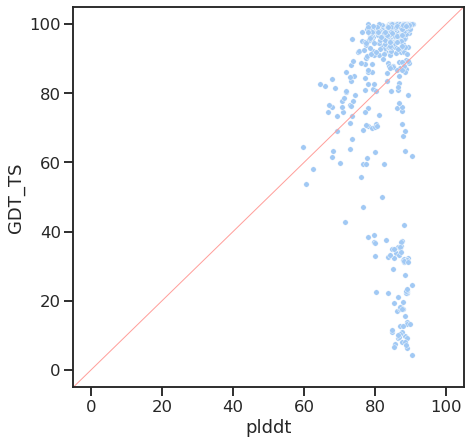

In [179]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=gdt_vs_plddt, x="plddt", y="value", s = 30)
ax.set(ylabel = "GDT_TS")
#.set(xlim=(0,100),ylim=(0,1))
ax.axline((0, 0), (100, 100), linewidth=1, color='r')

[Text(0, 0.5, 'GDT_TS')]

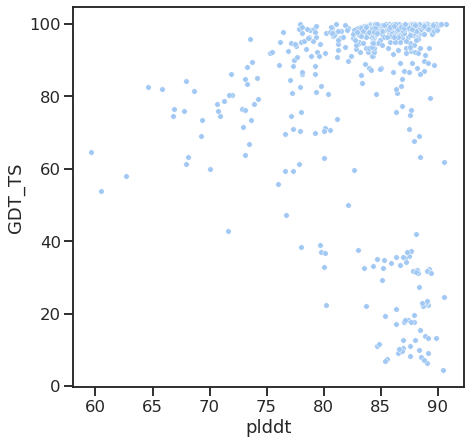

In [180]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(data=gdt_vs_plddt, x="plddt", y="value", s = 30)
ax.set(ylabel = "GDT_TS")


[Text(0.5, 0, 'Spearman coefficient (plddt vs GDT_TS)')]

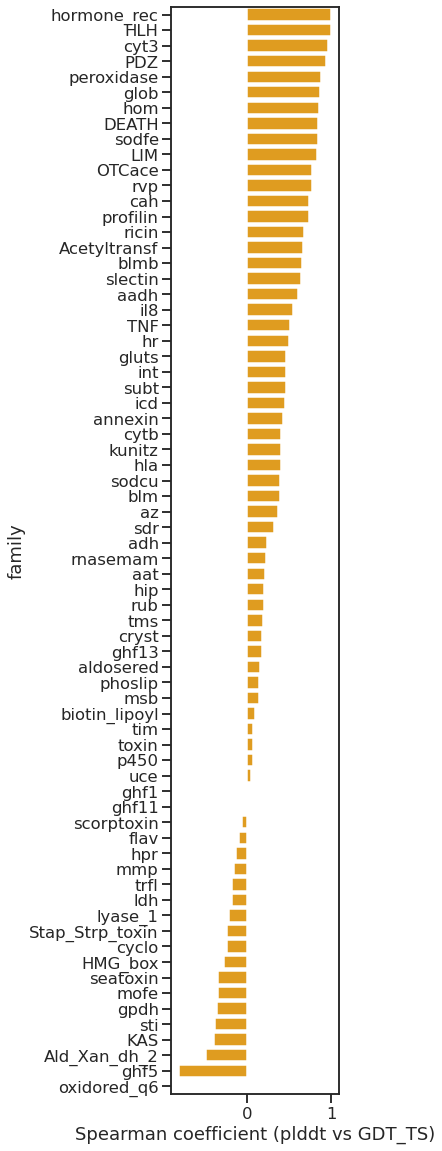

In [181]:
# Check the distibution of the correlations across families

df = pd.DataFrame(gdt_vs_plddt.groupby("family")[["plddt", "value"]].corr().unstack().iloc[:,1])
#df.columns =["family", "corr"]
df = df.reset_index()
df.columns = ["family", "corr"]
df = df.merge(msa_qualities, on = ["family"])

plt.figure(figsize=(3,20))
#plot = plt.scatter(df["family"], df["corr"], c=df["sp_3D"], cmap='Reds')
#plt.clf()
#cbar = plt.colorbar(plot)
#cbar.set_label('sp_3D', rotation=270)

df = df.sort_values(by = "corr", ascending = False)
ax= sns.barplot(x='corr', y='family', data=df, ci=None, dodge = False, color = "orange")
ax.set(xlabel='Spearman coefficient (plddt vs GDT_TS)')



In [296]:
df_d_r_wgdt[["n_sequences_ref_3D", "tcs_tot_3D" ]].corr()

,n_sequences_ref_3D,tcs_tot_3D
n_sequences_ref_3D,1.000000,-0.171114
tcs_tot_3D,-0.171114,1.000000


### Check general expectations



In [189]:
#x_vars = ["sim_tot_3D", "tcs_tot_3D","plddt_max_3D", "gdt_mean"]
x_vars = ["plddt_min_FAMSA", "tcs_tot_3D", "gdt_min"]
#x_vars = ["plddt_min_FAMSA", "plddt_mean_FAMSA", "plddt_max_FAMSA"]
#x_vars = ["gdt_min", "gdt_mean", "gdt_max"]
y_vars = ["sp_3D", "tc_3D"]
assay_combos = list(itertools.product(x_vars, y_vars))

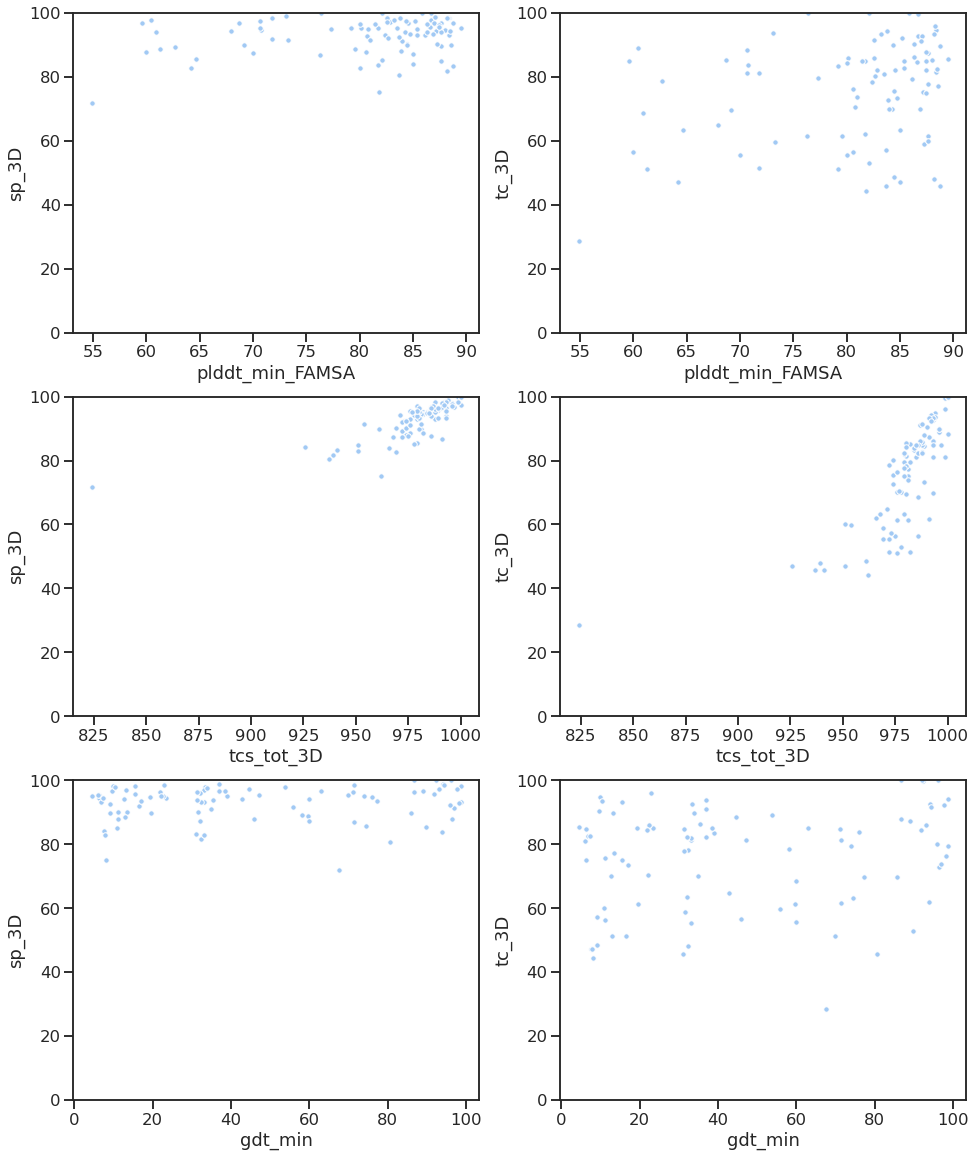

In [192]:
sns.set_theme(style="ticks", palette="pastel")
sns.set_context("talk")
fig, axes = plt.subplots(3, 2, figsize=(16,20))

def scatter_bench(x,y,i,j, legend = False):
    g = sns.scatterplot(ax=axes[i, j],data = df_d_r_wgdt, x=x, y=y,  \
                         linewidth = 1, s = 30, legend = legend)
    #g.axline((0, 0), (100, 100), linewidth=1, color='r')
    g.set(ylim=(0,100))

    if(legend == True):
        g.legend(bbox_to_anchor=(0.7, 1.35), borderaxespad=0, fontsize='x-large')

assay = 0 
for i in range(0,3):
    for j in range (0,2): 
        scatter_bench(assay_combos[assay][0], assay_combos[assay][1], i,j)
        assay += 1


# Check for the families where we are doing worse 

In [208]:
problematic_families = df_d_r_wgdt[df_d_r_wgdt.perc_change_sp < 0]
problematic_families.family.count()

12

<AxesSubplot:xlabel='perc_change_sp', ylabel='Count'>

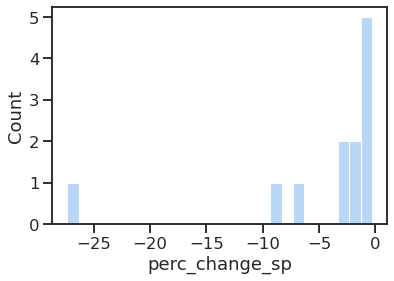

In [209]:
# How much worse are we doing? 
sns.histplot(data=problematic_families, x="perc_change_sp", binwidth = 1)

# Extract the minimum TCS

In [210]:
# ---------------------------------------------------------
# Get TCS (and store for future notebooks) 
# ---------------------------------------------------------
tcss = os.path.join(evaluation_dir,"homfam/evaluation/tcs/*.tcs")
tcss_3d = os.path.join(evaluation_dir,"homfam/alignments/*/*/*.tcs")
tcs_paths = list(glob.glob(tcss)) + list(glob.glob(tcss_3d))
tcs_df_complete = pd.DataFrame()

In [211]:
for file in tcs_paths:
    full_name = file.split(sep = "/")[-1].replace(".tcs", "")
    file_opened = open(file, "r")
    #tot_line = [line.split(sep = ":") for line in file_opened if line.contains(':')]
    for line in file_opened: 
        if ":" in line and "CPU" not in line: 
            s_line = line.split(sep = ":")
            entry = pd.DataFrame({'name_3D':[full_name], 'sequence': [s_line[0].strip()],"tcs": s_line[1].strip()})
            tcs_df_complete =  pd.concat([tcs_df_complete, entry], ignore_index = True)

In [212]:
min_tcs = pd.DataFrame(tcs_df_complete.groupby(by = "name_3D")["tcs"].min()).reset_index()
min_tcs = min_tcs.rename(columns={'tcs': 'min_tcs'})
min_tcs = min_tcs.astype({'min_tcs':'int'})

In [219]:
df = pd.merge(df_d_r_wgdt, min_tcs, on = "name_3D")
df["problematic_family"] = "ok"
df.loc[df.perc_change_sp < 0, 'problematic_family'] = "problematic"
df = df[df.family.isin(problematic_families.family)]

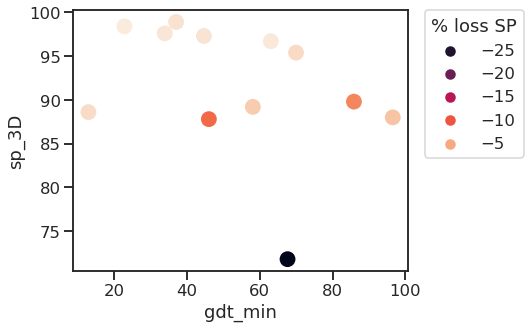

In [230]:
# 1. Expectations: TCS vs SP
plt.figure(figsize=(6,4.8))

x_var = "plddt_min_3D"
x_var = "gdt_min"

y_var = "sp_3D"
hue_var = "perc_change_sp"

sns.scatterplot(data = df, x = x_var, y = y_var, hue= hue_var, \
                edgecolor = "grey", linewidth = 0, palette = "rocket", s = 250)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "% loss SP")


## Are the same sequences having the low plddt the ones being the problem in TCS? 


In [287]:
tcs_df_complete = tcs_df_complete.astype({'sequence':'str'})
tcs_df_complete = tcs_df_complete.astype({'tcs':'int'})
summary_ref_af2 = summary_ref_af2.astype({'sequence':'str'})
df = pd.merge(tcs_df_complete, summary_ref_af2, on = "sequence" )
df[["family", "method", "align_method", "tree_method"]] = df.name_3D.str.split(".", expand = True)
df = df[df.align_method == "3DCOFFEE"]
df["family"] = df.family.str.split("-ref", expand = True)[0]
df = df.merge(gdt_summary, on = ["family", "sequence"])

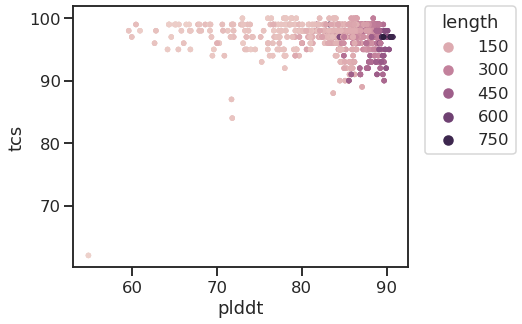

In [290]:
# 1. Expectations: TCS vs SP
plt.figure(figsize=(6,4.8))

x_var = "plddt"
y_var = "tcs"
hue_var = "length"

sns.scatterplot(data = df, x = x_var, y = y_var, hue= hue_var, \
                edgecolor = "grey", linewidth = 0,  s = 30)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "length")


In [ ]:
# Check only the problematic ones 

In [321]:
problematic_families

,name_3D,sp_3D,tc_3D,column_3D,family,method_3D,bucket_size_3D,align_method_3D,tree_method_3D,dynamicX_label_3D,...,plddt_mean_FAMSA,plddt_min_FAMSA,plddt_max_FAMSA,sim_tot_FAMSA,tcs_tot_FAMSA,diff_tc,diff_sp,perc_change_tc,perc_change_sp,diff_qualitatively
6,HLH-ref.progressive.3DCOFFEE.MBED,89.2,78.6,77.4,HLH,progressive,NaN,3DCOFFEE,MBED,NaN,...,73.734340,62.6524,80.1354,27.98,795,-5.9,-2.4,-6.982249,-2.620087,worst
19,HMG_box-ref.progressive.3DCOFFEE.MBED,96.7,85.2,93.9,HMG_box,progressive,NaN,3DCOFFEE,MBED,NaN,...,75.899900,68.6329,80.1560,24.69,822,0.0,-0.6,0.000000,-0.616650,worst
21,int-ref.progressive.3DCOFFEE.MBED,88.0,72.8,77.1,int,progressive,NaN,3DCOFFEE,MBED,NaN,...,84.861620,83.8319,86.2072,22.02,722,-2.4,-2.9,-3.191489,-3.190319,worst
24,ins-ref.progressive.3DCOFFEE.MBED,87.8,56.5,77.9,ins,progressive,NaN,3DCOFFEE,MBED,NaN,...,66.639933,59.9665,75.7398,44.79,936,-20.3,-8.5,-26.432292,-8.826584,worst
25,rhv-ref.progressive.3DCOFFEE.MBED,57.0,33.3,41.7,rhv,progressive,NaN,3DCOFFEE,MBED,NaN,...,71.582433,69.6655,73.3991,33.28,837,-17.1,-21.6,-33.928571,-27.480916,worst -10
27,myb_DNA-binding-ref.progressive.3DCOFFEE.MBED,89.8,69.6,78.2,myb_DNA-binding,progressive,NaN,3DCOFFEE,MBED,NaN,...,73.745080,69.1797,76.7059,40.86,848,-14.3,-7.0,-17.044100,-7.231405,worst
30,hr-ref.progressive.3DCOFFEE.MBED,98.9,93.7,97.7,hr,progressive,NaN,3DCOFFEE,MBED,NaN,...,79.470240,73.0645,82.8730,53.31,990,-6.3,-1.1,-6.300000,-1.100000,worst
32,ChtBD-ref.progressive.3DCOFFEE.MBED,97.3,88.4,90.8,ChtBD,progressive,NaN,3DCOFFEE,MBED,NaN,...,72.533880,70.6585,76.0055,58.72,941,-2.3,-1.0,-2.535832,-1.017294,worst
38,mmp-ref.progressive.3DCOFFEE.MBED,97.6,89.9,93.9,mmp,progressive,NaN,3DCOFFEE,MBED,NaN,...,85.521800,84.3517,85.9889,55.05,970,-3.0,-0.8,-3.229279,-0.813008,worst


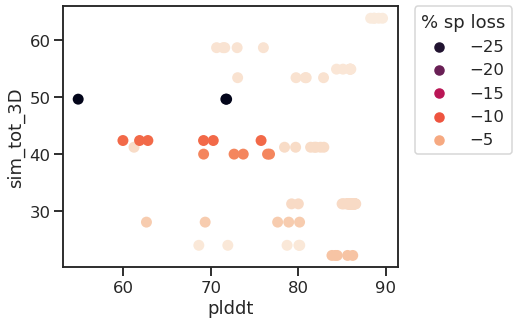

In [237]:
# 1. Expectations: TCS vs SP
plt.figure(figsize=(6,4.8))

x_var = "plddt"
y_var = "sim_tot_3D"
hue_var = "perc_change_sp"

sns.scatterplot(data = df_prob, x = x_var, y = y_var, hue= hue_var, \
                edgecolor = "grey", linewidth = 0, palette = "rocket", s = 120)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = "% sp loss")

# Check really the super problematic family 

In [255]:
df_prob = df[df.name_3D.isin(problematic_families.name_3D)]
df_prob = pd.merge(df_prob, df_d_r, on = "name_3D")
df_prob[df_prob.perc_change_sp < -10][["tcs", "plddt", "sim_tot_3D","sim_tot_FAMSA"]]

,tcs,plddt,sim_tot_3D,sim_tot_FAMSA
96,87,71.7192,49.68,64.12
97,84,71.8073,49.68,64.12
98,62,54.8571,49.68,64.12


In [307]:
print(pd.DataFrame(df_prob.columns).to_string())

                                    0
0                           name_full
1                            sequence
2                                 tcs
3                              length
4                                name
5                              subset
6                            family_x
7                               plddt
8                benchmarking_dataset
9                              method
10                       align_method
11                        tree_method
12                              sp_3D
13                              tc_3D
14                          column_3D
15                           family_y
16                          method_3D
17                     bucket_size_3D
18                    align_method_3D
19                     tree_method_3D
20                  dynamicX_label_3D
21                    dynamicX_val_3D
22                      master_msa_3D
23                       slave_msa_3D
24         benchmarking_dataset_3D_3D
25          

In [298]:
sns.scatterplot(df_prob, x = "tcs", y = "tcs_tot_3D") 

/home/luisasantus/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret value `tcs_tot_3D` for parameter `y`

In [271]:
df_prob = df_prob.rename(columns={"name_3D": "name_full"})
easel = easel.rename(columns={"name": "name_full"})


In [274]:
df_correlation_all

0     tgfb
1     tgfb
2     tgfb
3     tgfb
4     tgfb
      ... 
94     mmp
95     mmp
96     mmp
97     mmp
98     mmp
Name: family, Length: 99, dtype: object

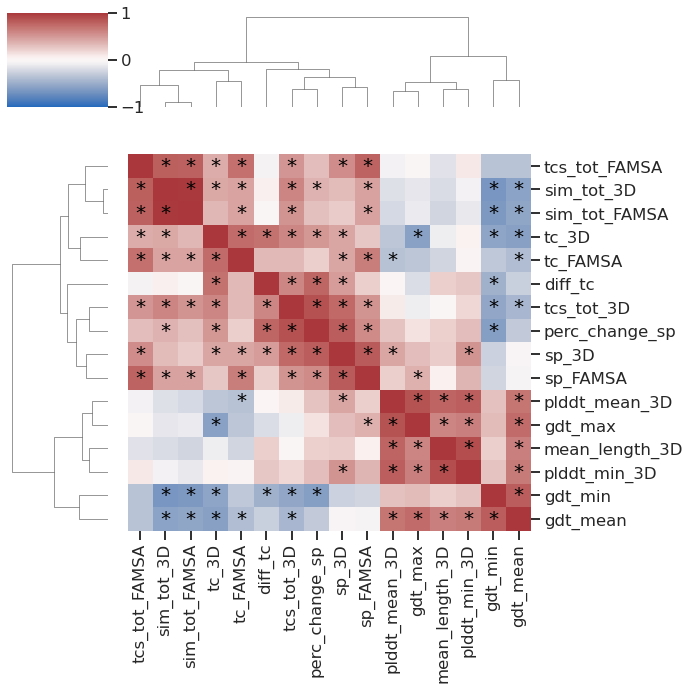

In [281]:
df_correlation_all = pd.merge(easel, df_prob, on = "name_full")
df_correlation_all["family"] = df_correlation_all["family_x"]

df_correlation_all = df_correlation_all.merge(gdtss, on = "family", how = "left")
df_correlation = df_correlation_all[["diff_tc","tc_3D","tc_FAMSA",\
                          "sp_3D","sp_FAMSA", "mean_length_3D",\
                          "plddt_min_3D", "plddt_mean_3D", "sim_tot_3D",\
                          "gdt_min", "gdt_mean", "gdt_max",\
                          "tcs_tot_3D", "sim_tot_FAMSA", "tcs_tot_FAMSA",\
                          "perc_change_sp", "Alignment length", "Average identity", "Average length"]]

#df_correlation.columns = ["diff_tc", "tc_structure", "tc_nostructure", "n_sequences_family", "mean_length", "plddt_mean"]
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
def get_correlations(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how="outer")
    correlations = dfcols.transpose().join(dfcols, how="outer")
    for ix, r in enumerate(df.columns):
        for jx, c in enumerate(df.columns):
            sp = spearmanr(df[r], df[c])
            correlations[c][r] = sp[0]
            pvalues[c][r] = sp[1] if ix > jx else np.nan  # Only store values below the diagonal
    return correlations.astype("float"), pvalues.astype("float")


correlations, uncorrected_p_values = get_correlations(df_correlation)

# Correct p-values for multiple testing and check significance (True if the corrected p-value < 0.05)
shape = uncorrected_p_values.values.shape
significant_matrix = multipletests(uncorrected_p_values.values.flatten())[0].reshape(
    shape
)

# Here we start plotting
g = sns.clustermap(correlations, cmap="vlag", vmin=-1, vmax=1)

# Here labels on the y-axis are rotated
for tick in g.ax_heatmap.get_yticklabels():
    tick.set_rotation(0)

# Here we add asterisks onto cells with signficant correlations
for i, ix in enumerate(g.dendrogram_row.reordered_ind):
    for j, jx in enumerate(g.dendrogram_row.reordered_ind):
        if i != j:
            text = g.ax_heatmap.text(
                j + 0.5,
                i + 0.5,
                "*" if significant_matrix[ix, jx] or significant_matrix[jx, ix] else "",
                ha="center",
                va="center",
                color="black",
            )
            text.set_fontsize(20)

# Save a high-res copy of the image to disk
plt.tight_layout()
plt.savefig("clustermap.png", dpi=200)

In [258]:
# Extract from .score files 
dataset = "homfam"
easel_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/easel/")
easel = pd.DataFrame()
for easel_name in os.listdir(easel_dir):
    easel_file = os.path.join(easel_dir,easel_name)
    # Parse file
    if easel_file.endswith("INFO"):
        easel_df = pd.read_csv(easel_file,sep = ":", header = None).drop([0,1,9], axis = 0)
        easel_df[1] = easel_df[1].str.strip()
        easel_df = easel_df.set_index(0).T
        easel_df["name"] = easel_name.replace(".easel_INFO", "")
        easel = easel.append(easel_df, ignore_index=True)

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov

/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easel = easel.append(easel_df, ignore_index=True)
/tmp/ipykernel_9444/3160288920.py:13: FutureWarning: The frame.append method is deprecated and will be remov